In [ ]:
!pip install torchvision tensorboardx jupyter matplotlib numpy

     |████████████████████████████████| 194kB 3.0MB/s 


In [ ]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Dataset/celeba_128.zip' -d '/content/'

In [ ]:
import os
dst = '/content/celeba_128/img_align_celeba/'
names = os.listdir(dst)
print(len(names))

50000


In [ ]:
import glob
import imageio

im = imageio.imread(dst+names[1])

print (im.shape)
print (im.dtype)

(128, 128, 3)
uint8


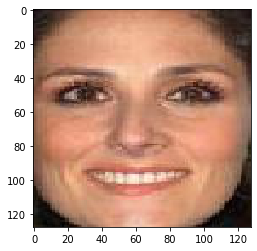

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(im)

In [ ]:
from utils import Logger

In [ ]:
compose = transforms.Compose(
        [
         #transforms.Grayscale(num_output_channels=1),
         transforms.Resize(size = (64,64)),
         transforms.ToTensor(),
         transforms.Normalize((0.5,0.5,0.5), (.5,.5,.5)),
        ])
data = datasets.ImageFolder(root = '/content/celeba_128/',transform=compose)

In [ ]:
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

In [ ]:
num_batches = len(data_loader)
print(num_batches)

500


In [ ]:
data

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /content/celeba_128/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), 3,64,64)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 64, 64)

In [ ]:
enumerate(data_loader)

In [ ]:
class GeneratorNet(torch.nn.Module):

  """
  A three hidden-layer generative neural network
  """
  def __init__(self,d =128):
    super(GeneratorNet, self).__init__()
    n_features = 100
    #layerdeconv1
    self.deconv1 = nn.Sequential(
        nn.ConvTranspose2d(n_features,d*8,4,1,0,bias= False),
        nn.BatchNorm2d(d*8),
        nn.ReLU()
    )
    torch.nn.init.normal_(self.deconv1[0].weight,mean=0,std=0.02)

    #layerdeconv2
    self.deconv2 = nn.Sequential(            
        nn.ConvTranspose2d(d*8,d*4,4,2,1,bias= False),
        nn.BatchNorm2d(d*4),
        nn.ReLU()
    )
    torch.nn.init.normal_(self.deconv2[0].weight,mean=0,std=0.02)

        ##layerdeconv3
    self.deconv3 = nn.Sequential(
        nn.ConvTranspose2d(d*4,d*2,4,2,1,bias= False),
        nn.BatchNorm2d(d*2),
        nn.ReLU()
    )
    torch.nn.init.normal_(self.deconv3[0].weight,mean=0,std=0.02)

        #layerdeconv4
    self.deconv4 = nn.Sequential(
        nn.ConvTranspose2d(d*2,d*1,4,2,1,bias= False),
        nn.BatchNorm2d(d*1),
        nn.ReLU()
    )
    torch.nn.init.normal_(self.deconv4[0].weight,mean=0,std=0.02)
  
    self.out = nn.Sequential(
        nn.ConvTranspose2d(d,3,4,2,1,bias= False),
        nn.Tanh()
    )
    torch.nn.init.normal_(self.out[0].weight,mean=0,std=0.02)
        

  def forward(self, x):
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)
    x = self.deconv4(x)
    x = self.out(x)
    return x
generator = GeneratorNet()


In [ ]:
class DiscriminatorNet(torch.nn.Module):
  """
   3 layer Neural Network
  """
  def __init__(self,d=128):
    super(DiscriminatorNet,self).__init__()
    n_out = 1

    self.conv1 = nn.Sequential( 
        nn.Conv2d(3,d,4,2,1,bias=False),
        nn.LeakyReLU(0.2),
      )
    torch.nn.init.normal_(self.conv1[0].weight,mean=0,std=0.02)
    self.conv2 = nn.Sequential(
        nn.Conv2d(d,d*2,4,2,1,bias=False),
        nn.BatchNorm2d(d*2),
        nn.LeakyReLU(0.2),
    )
    torch.nn.init.normal_(self.conv2[0].weight,mean=0,std=0.02)
    self.conv3 = nn.Sequential(
        nn.Conv2d(d*2,d*4,4,2,1,bias=False),
        nn.BatchNorm2d(d*4),
        nn.LeakyReLU(0.2),
    )
    torch.nn.init.normal_(self.conv3[0].weight,mean=0,std=0.02)
    self.conv4 = nn.Sequential(
        nn.Conv2d(d*4,d*8,4,2,1,bias=False),
        nn.BatchNorm2d(d*8),
        nn.LeakyReLU(0.2),
    )

    torch.nn.init.normal_(self.conv4[0].weight,mean=0,std=0.02)
    
  

    self.out = nn.Sequential(
        nn.Conv2d(d*8,1,4,1,0,bias=False),
        nn.Sigmoid(),   
    )
    torch.nn.init.normal_(self.out[0].weight,mean=0,std=0.02)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.out(x)
    return x

discriminator = DiscriminatorNet()

In [ ]:
if torch.cuda.is_available():
  generator = generator.cuda()
  discriminator = discriminator.cuda()
else:
  print('Not Cuda')

In [ ]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size,100,1,1))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [ ]:
loss = nn.BCELoss()

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00004,betas=(0.5,0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.00015,betas=(0.5,0.999))

In [ ]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1,1,1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1,1,1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [ ]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

0
Epoch: [0/5], Batch Num: [0/500]
Discriminator Loss: 1.1791, Generator Loss: 0.4169
D(x): 0.4494, D(G(z)): 0.2149


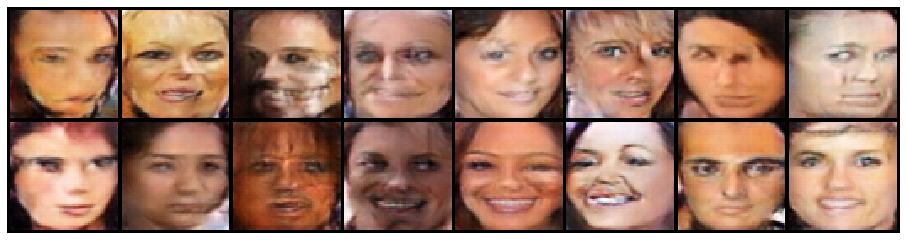

Epoch: [0/5], Batch Num: [20/500]
Discriminator Loss: 1.0470, Generator Loss: 1.4660
D(x): 0.6458, D(G(z)): 0.4032
Epoch: [0/5], Batch Num: [40/500]
Discriminator Loss: 0.9913, Generator Loss: 1.5710
D(x): 0.7134, D(G(z)): 0.4372
Epoch: [0/5], Batch Num: [60/500]
Discriminator Loss: 1.0041, Generator Loss: 1.1467
D(x): 0.5624, D(G(z)): 0.3037
Epoch: [0/5], Batch Num: [80/500]
Discriminator Loss: 1.0641, Generator Loss: 1.8275
D(x): 0.7619, D(G(z)): 0.5150
Epoch: [0/5], Batch Num: [100/500]
Discriminator Loss: 0.8912, Generator Loss: 1.7856
D(x): 0.7543, D(G(z)): 0.4133


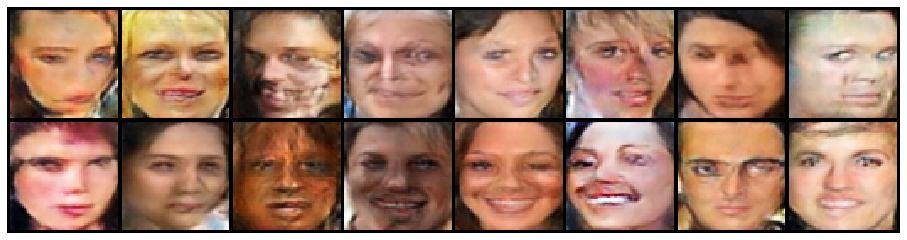

Epoch: [0/5], Batch Num: [120/500]
Discriminator Loss: 1.4176, Generator Loss: 1.3457
D(x): 0.3102, D(G(z)): 0.0871
Epoch: [0/5], Batch Num: [140/500]
Discriminator Loss: 1.0669, Generator Loss: 1.7389
D(x): 0.6208, D(G(z)): 0.3872
Epoch: [0/5], Batch Num: [160/500]
Discriminator Loss: 1.0254, Generator Loss: 1.8151
D(x): 0.7234, D(G(z)): 0.4590
Epoch: [0/5], Batch Num: [180/500]
Discriminator Loss: 1.0448, Generator Loss: 1.9521
D(x): 0.8732, D(G(z)): 0.5559
Epoch: [0/5], Batch Num: [200/500]
Discriminator Loss: 1.0820, Generator Loss: 1.8900
D(x): 0.8408, D(G(z)): 0.5626


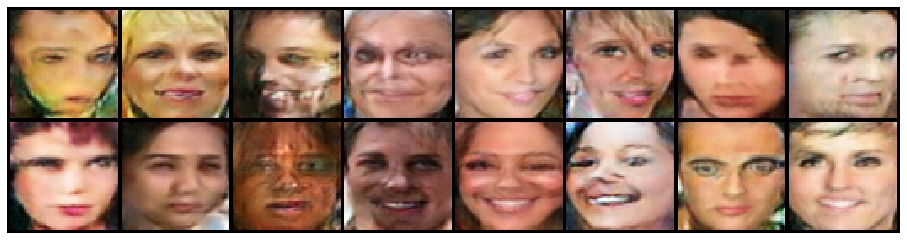

Epoch: [0/5], Batch Num: [220/500]
Discriminator Loss: 0.9754, Generator Loss: 1.2823
D(x): 0.7144, D(G(z)): 0.4366
Epoch: [0/5], Batch Num: [240/500]
Discriminator Loss: 1.0494, Generator Loss: 0.9392
D(x): 0.5272, D(G(z)): 0.2864
Epoch: [0/5], Batch Num: [260/500]
Discriminator Loss: 0.9830, Generator Loss: 1.1588
D(x): 0.5108, D(G(z)): 0.2046
Epoch: [0/5], Batch Num: [280/500]
Discriminator Loss: 0.8874, Generator Loss: 1.3849
D(x): 0.6717, D(G(z)): 0.3437
Epoch: [0/5], Batch Num: [300/500]
Discriminator Loss: 0.9824, Generator Loss: 1.2919
D(x): 0.5611, D(G(z)): 0.2861


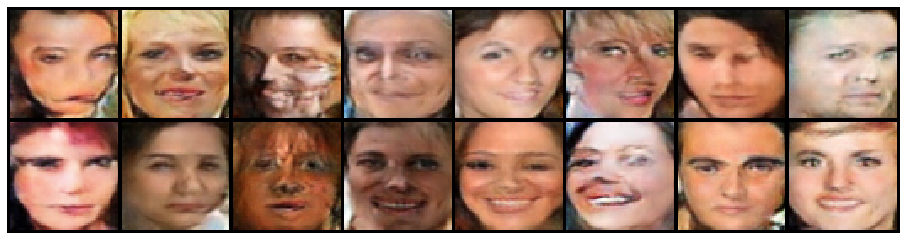

Epoch: [0/5], Batch Num: [320/500]
Discriminator Loss: 0.9082, Generator Loss: 1.5995
D(x): 0.7894, D(G(z)): 0.4567
Epoch: [0/5], Batch Num: [340/500]
Discriminator Loss: 1.0037, Generator Loss: 1.1371
D(x): 0.5629, D(G(z)): 0.2997
Epoch: [0/5], Batch Num: [360/500]
Discriminator Loss: 0.8262, Generator Loss: 1.3040
D(x): 0.6598, D(G(z)): 0.3019
Epoch: [0/5], Batch Num: [380/500]
Discriminator Loss: 0.8876, Generator Loss: 1.2547
D(x): 0.6432, D(G(z)): 0.3113
Epoch: [0/5], Batch Num: [400/500]
Discriminator Loss: 0.8826, Generator Loss: 1.1089
D(x): 0.5416, D(G(z)): 0.1916


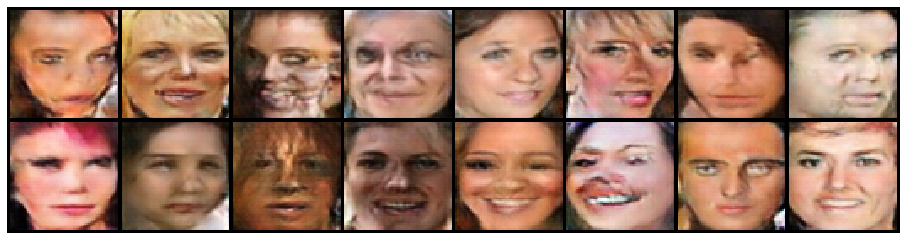

Epoch: [0/5], Batch Num: [420/500]
Discriminator Loss: 1.0596, Generator Loss: 2.4317
D(x): 0.7606, D(G(z)): 0.5098
Epoch: [0/5], Batch Num: [440/500]
Discriminator Loss: 0.9571, Generator Loss: 1.2392
D(x): 0.5475, D(G(z)): 0.2551
Epoch: [0/5], Batch Num: [460/500]
Discriminator Loss: 0.8876, Generator Loss: 2.4146
D(x): 0.8272, D(G(z)): 0.4739
Epoch: [0/5], Batch Num: [480/500]
Discriminator Loss: 1.0174, Generator Loss: 1.6641
D(x): 0.5567, D(G(z)): 0.2938
1
Epoch: [1/5], Batch Num: [0/500]
Discriminator Loss: 0.9214, Generator Loss: 2.1104
D(x): 0.8124, D(G(z)): 0.4707


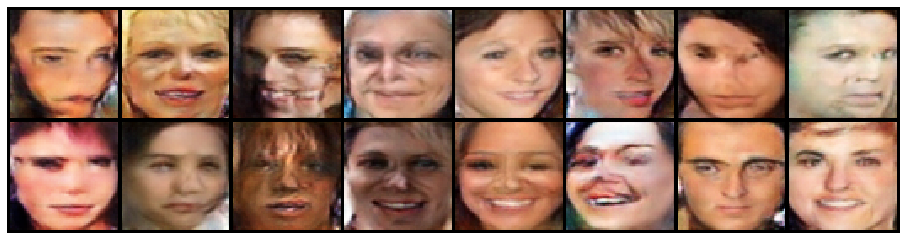

Epoch: [1/5], Batch Num: [20/500]
Discriminator Loss: 0.8999, Generator Loss: 1.1857
D(x): 0.5909, D(G(z)): 0.2631
Epoch: [1/5], Batch Num: [40/500]
Discriminator Loss: 1.2785, Generator Loss: 1.7432
D(x): 0.3382, D(G(z)): 0.0558
Epoch: [1/5], Batch Num: [60/500]
Discriminator Loss: 0.7860, Generator Loss: 1.8658
D(x): 0.7191, D(G(z)): 0.3301
Epoch: [1/5], Batch Num: [80/500]
Discriminator Loss: 0.8589, Generator Loss: 1.2192
D(x): 0.6145, D(G(z)): 0.2649
Epoch: [1/5], Batch Num: [100/500]
Discriminator Loss: 0.9703, Generator Loss: 1.4564
D(x): 0.5628, D(G(z)): 0.2627


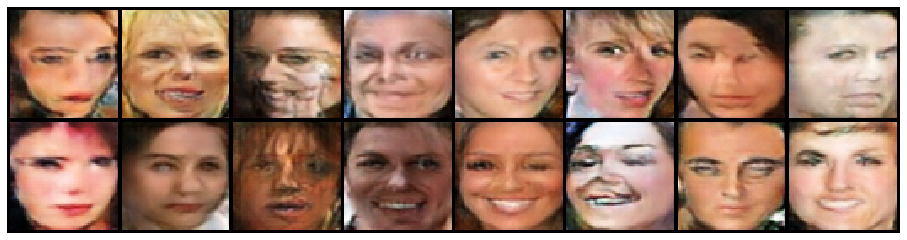

Epoch: [1/5], Batch Num: [120/500]
Discriminator Loss: 0.7506, Generator Loss: 1.4684
D(x): 0.7320, D(G(z)): 0.3264
Epoch: [1/5], Batch Num: [140/500]
Discriminator Loss: 1.1648, Generator Loss: 1.7529
D(x): 0.6267, D(G(z)): 0.4381
Epoch: [1/5], Batch Num: [160/500]
Discriminator Loss: 0.9165, Generator Loss: 1.0297
D(x): 0.5988, D(G(z)): 0.2714
Epoch: [1/5], Batch Num: [180/500]
Discriminator Loss: 1.0362, Generator Loss: 1.7756
D(x): 0.6902, D(G(z)): 0.4368
Epoch: [1/5], Batch Num: [200/500]
Discriminator Loss: 0.9842, Generator Loss: 1.0661
D(x): 0.5867, D(G(z)): 0.3179


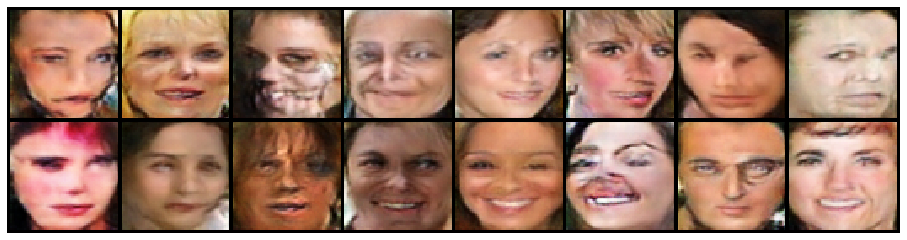

Epoch: [1/5], Batch Num: [220/500]
Discriminator Loss: 1.0125, Generator Loss: 1.5843
D(x): 0.5889, D(G(z)): 0.3414
Epoch: [1/5], Batch Num: [240/500]
Discriminator Loss: 0.8802, Generator Loss: 1.5518
D(x): 0.7413, D(G(z)): 0.4087
Epoch: [1/5], Batch Num: [260/500]
Discriminator Loss: 0.7735, Generator Loss: 1.5538
D(x): 0.6484, D(G(z)): 0.2559
Epoch: [1/5], Batch Num: [280/500]
Discriminator Loss: 1.2313, Generator Loss: 0.8066
D(x): 0.3992, D(G(z)): 0.1819
Epoch: [1/5], Batch Num: [300/500]
Discriminator Loss: 0.7025, Generator Loss: 1.8656
D(x): 0.7854, D(G(z)): 0.3376


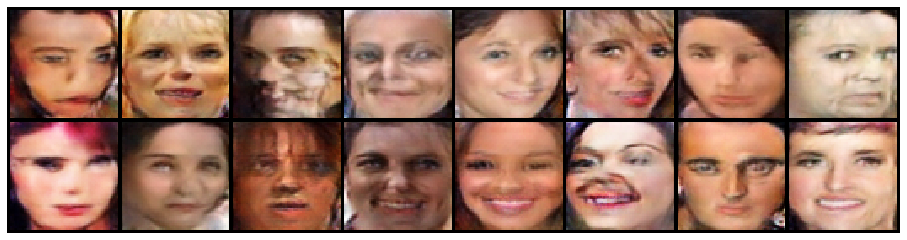

Epoch: [1/5], Batch Num: [320/500]
Discriminator Loss: 1.1165, Generator Loss: 1.0177
D(x): 0.4823, D(G(z)): 0.2397
Epoch: [1/5], Batch Num: [340/500]
Discriminator Loss: 1.0623, Generator Loss: 1.6302
D(x): 0.8120, D(G(z)): 0.5370
Epoch: [1/5], Batch Num: [360/500]
Discriminator Loss: 0.7790, Generator Loss: 1.7673
D(x): 0.7125, D(G(z)): 0.3260
Epoch: [1/5], Batch Num: [380/500]
Discriminator Loss: 1.1003, Generator Loss: 0.8327
D(x): 0.4603, D(G(z)): 0.2038
Epoch: [1/5], Batch Num: [400/500]
Discriminator Loss: 0.8327, Generator Loss: 1.7618
D(x): 0.6903, D(G(z)): 0.3362


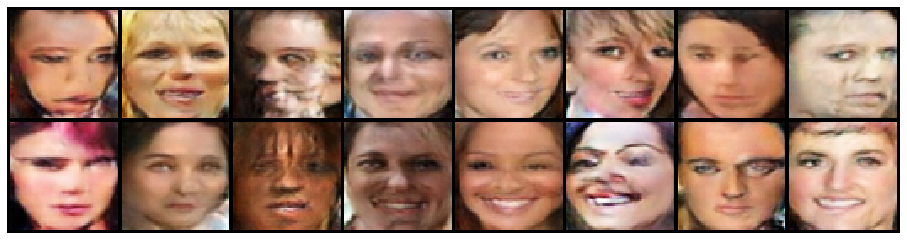

Epoch: [1/5], Batch Num: [420/500]
Discriminator Loss: 1.0922, Generator Loss: 2.0036
D(x): 0.7137, D(G(z)): 0.4840
Epoch: [1/5], Batch Num: [440/500]
Discriminator Loss: 0.9177, Generator Loss: 1.6292
D(x): 0.6398, D(G(z)): 0.3339
Epoch: [1/5], Batch Num: [460/500]
Discriminator Loss: 1.3834, Generator Loss: 1.0511
D(x): 0.3261, D(G(z)): 0.1401
Epoch: [1/5], Batch Num: [480/500]
Discriminator Loss: 1.0509, Generator Loss: 1.5892
D(x): 0.8222, D(G(z)): 0.5287
2
Epoch: [2/5], Batch Num: [0/500]
Discriminator Loss: 0.9950, Generator Loss: 1.8195
D(x): 0.7458, D(G(z)): 0.4704


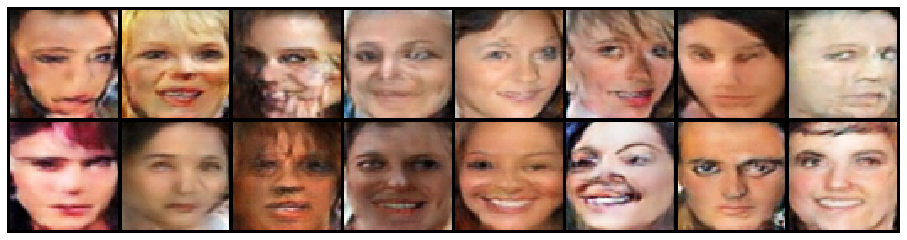

Epoch: [2/5], Batch Num: [20/500]
Discriminator Loss: 0.9791, Generator Loss: 1.6219
D(x): 0.7331, D(G(z)): 0.4525
Epoch: [2/5], Batch Num: [40/500]
Discriminator Loss: 0.9501, Generator Loss: 1.2143
D(x): 0.5597, D(G(z)): 0.2581
Epoch: [2/5], Batch Num: [60/500]
Discriminator Loss: 0.8609, Generator Loss: 1.3034
D(x): 0.6252, D(G(z)): 0.2823
Epoch: [2/5], Batch Num: [80/500]
Discriminator Loss: 1.3594, Generator Loss: 2.2623
D(x): 0.6514, D(G(z)): 0.5555
Epoch: [2/5], Batch Num: [100/500]
Discriminator Loss: 1.0933, Generator Loss: 0.8833
D(x): 0.4561, D(G(z)): 0.2047


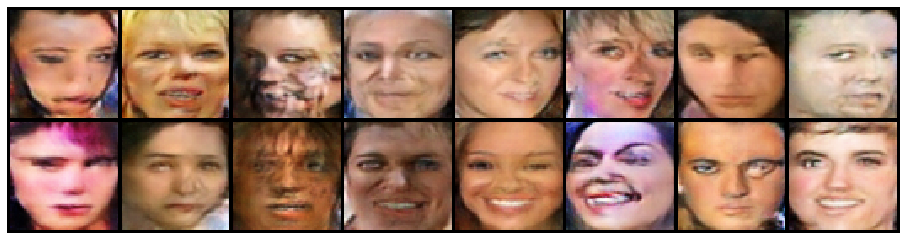

Epoch: [2/5], Batch Num: [120/500]
Discriminator Loss: 1.1309, Generator Loss: 0.8113
D(x): 0.4235, D(G(z)): 0.1660
Epoch: [2/5], Batch Num: [140/500]
Discriminator Loss: 0.7601, Generator Loss: 1.5290
D(x): 0.7609, D(G(z)): 0.3584
Epoch: [2/5], Batch Num: [160/500]
Discriminator Loss: 1.0064, Generator Loss: 1.2620
D(x): 0.5329, D(G(z)): 0.2524
Epoch: [2/5], Batch Num: [180/500]
Discriminator Loss: 0.8933, Generator Loss: 1.3423
D(x): 0.5523, D(G(z)): 0.2104
Epoch: [2/5], Batch Num: [200/500]
Discriminator Loss: 0.9485, Generator Loss: 0.9619
D(x): 0.5762, D(G(z)): 0.2769


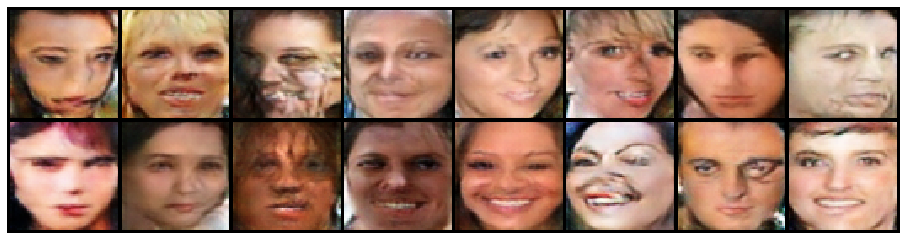

Epoch: [2/5], Batch Num: [220/500]
Discriminator Loss: 1.0752, Generator Loss: 1.1361
D(x): 0.5639, D(G(z)): 0.3428
Epoch: [2/5], Batch Num: [240/500]
Discriminator Loss: 0.9545, Generator Loss: 1.1281
D(x): 0.5365, D(G(z)): 0.2228
Epoch: [2/5], Batch Num: [260/500]
Discriminator Loss: 0.9347, Generator Loss: 2.4840
D(x): 0.6357, D(G(z)): 0.3335
Epoch: [2/5], Batch Num: [280/500]
Discriminator Loss: 1.1278, Generator Loss: 1.5877
D(x): 0.4472, D(G(z)): 0.2014
Epoch: [2/5], Batch Num: [300/500]
Discriminator Loss: 1.0732, Generator Loss: 1.4149
D(x): 0.6087, D(G(z)): 0.3943


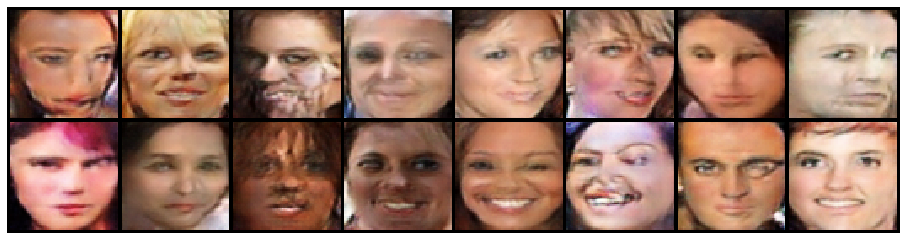

Epoch: [2/5], Batch Num: [320/500]
Discriminator Loss: 0.9411, Generator Loss: 0.9560
D(x): 0.5612, D(G(z)): 0.2414
Epoch: [2/5], Batch Num: [340/500]
Discriminator Loss: 0.9467, Generator Loss: 1.5733
D(x): 0.6568, D(G(z)): 0.3625
Epoch: [2/5], Batch Num: [360/500]
Discriminator Loss: 0.9765, Generator Loss: 1.0237
D(x): 0.5588, D(G(z)): 0.2776
Epoch: [2/5], Batch Num: [380/500]
Discriminator Loss: 0.9661, Generator Loss: 1.4561
D(x): 0.6544, D(G(z)): 0.3820
Epoch: [2/5], Batch Num: [400/500]
Discriminator Loss: 0.8372, Generator Loss: 1.9535
D(x): 0.7055, D(G(z)): 0.3527


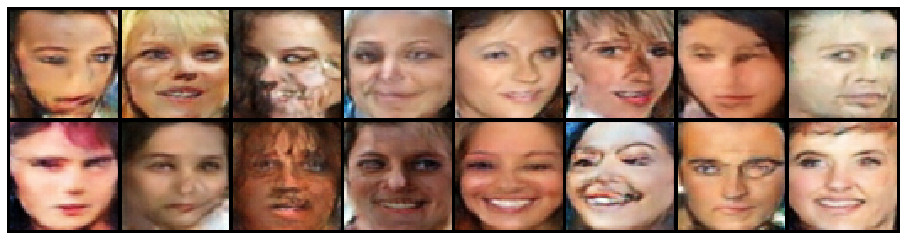

Epoch: [2/5], Batch Num: [420/500]
Discriminator Loss: 1.0553, Generator Loss: 1.8312
D(x): 0.7505, D(G(z)): 0.4958
Epoch: [2/5], Batch Num: [440/500]
Discriminator Loss: 0.9799, Generator Loss: 0.9215
D(x): 0.5657, D(G(z)): 0.2812
Epoch: [2/5], Batch Num: [460/500]
Discriminator Loss: 0.7118, Generator Loss: 1.8128
D(x): 0.7036, D(G(z)): 0.2674
Epoch: [2/5], Batch Num: [480/500]
Discriminator Loss: 1.1439, Generator Loss: 0.9990
D(x): 0.4582, D(G(z)): 0.2282
3
Epoch: [3/5], Batch Num: [0/500]
Discriminator Loss: 0.8400, Generator Loss: 4.1169
D(x): 0.9094, D(G(z)): 0.4909


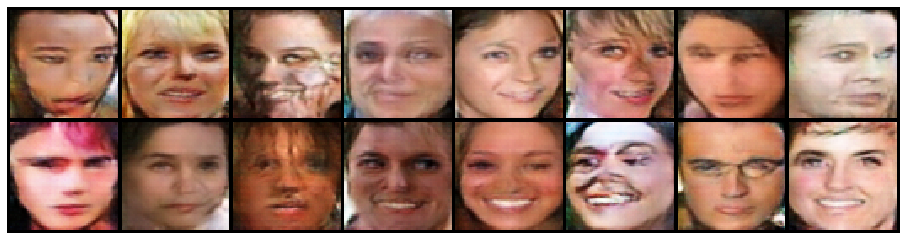

Epoch: [3/5], Batch Num: [20/500]
Discriminator Loss: 1.0275, Generator Loss: 1.3992
D(x): 0.4860, D(G(z)): 0.1882
Epoch: [3/5], Batch Num: [40/500]
Discriminator Loss: 1.0180, Generator Loss: 1.4636
D(x): 0.4619, D(G(z)): 0.1509
Epoch: [3/5], Batch Num: [60/500]
Discriminator Loss: 1.0419, Generator Loss: 1.1990
D(x): 0.6480, D(G(z)): 0.4031
Epoch: [3/5], Batch Num: [80/500]
Discriminator Loss: 0.9174, Generator Loss: 1.3764
D(x): 0.6544, D(G(z)): 0.3481
Epoch: [3/5], Batch Num: [100/500]
Discriminator Loss: 0.8170, Generator Loss: 1.4455
D(x): 0.6816, D(G(z)): 0.3195


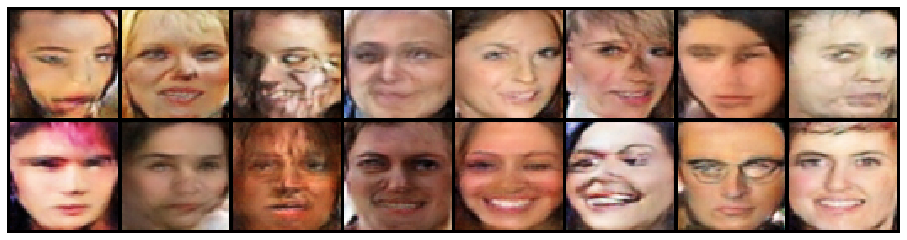

Epoch: [3/5], Batch Num: [120/500]
Discriminator Loss: 0.9922, Generator Loss: 2.7094
D(x): 0.7922, D(G(z)): 0.4949
Epoch: [3/5], Batch Num: [140/500]
Discriminator Loss: 0.8739, Generator Loss: 2.1908
D(x): 0.7995, D(G(z)): 0.4499
Epoch: [3/5], Batch Num: [160/500]
Discriminator Loss: 0.9346, Generator Loss: 0.9924
D(x): 0.5688, D(G(z)): 0.2622
Epoch: [3/5], Batch Num: [180/500]
Discriminator Loss: 1.1246, Generator Loss: 2.3616
D(x): 0.8468, D(G(z)): 0.5793
Epoch: [3/5], Batch Num: [200/500]
Discriminator Loss: 0.9240, Generator Loss: 0.9897
D(x): 0.5562, D(G(z)): 0.2292


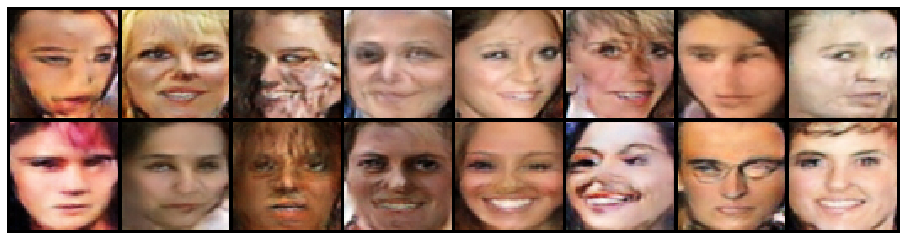

Epoch: [3/5], Batch Num: [220/500]
Discriminator Loss: 1.0439, Generator Loss: 1.1367
D(x): 0.4923, D(G(z)): 0.2129
Epoch: [3/5], Batch Num: [240/500]
Discriminator Loss: 1.0579, Generator Loss: 1.2808
D(x): 0.6182, D(G(z)): 0.3989
Epoch: [3/5], Batch Num: [260/500]
Discriminator Loss: 1.3201, Generator Loss: 2.3067
D(x): 0.8615, D(G(z)): 0.6556
Epoch: [3/5], Batch Num: [280/500]
Discriminator Loss: 0.8811, Generator Loss: 1.4793
D(x): 0.6126, D(G(z)): 0.2863
Epoch: [3/5], Batch Num: [300/500]
Discriminator Loss: 1.0145, Generator Loss: 2.2829
D(x): 0.5482, D(G(z)): 0.2695


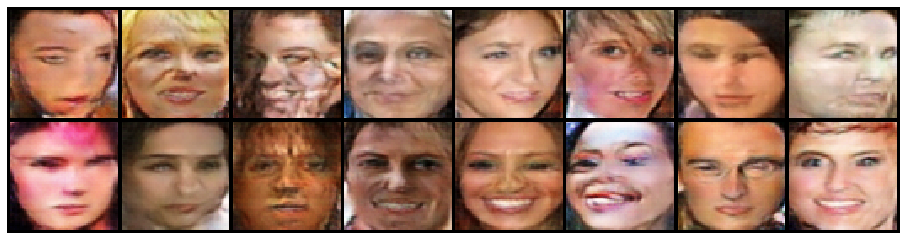

Epoch: [3/5], Batch Num: [320/500]
Discriminator Loss: 0.8875, Generator Loss: 1.8059
D(x): 0.6580, D(G(z)): 0.3315
Epoch: [3/5], Batch Num: [340/500]
Discriminator Loss: 0.9791, Generator Loss: 1.3249
D(x): 0.6312, D(G(z)): 0.3497
Epoch: [3/5], Batch Num: [360/500]
Discriminator Loss: 1.0022, Generator Loss: 0.9699
D(x): 0.5601, D(G(z)): 0.2922
Epoch: [3/5], Batch Num: [380/500]
Discriminator Loss: 0.7348, Generator Loss: 1.5367
D(x): 0.6903, D(G(z)): 0.2755
Epoch: [3/5], Batch Num: [400/500]
Discriminator Loss: 0.8871, Generator Loss: 1.5831
D(x): 0.7302, D(G(z)): 0.4021


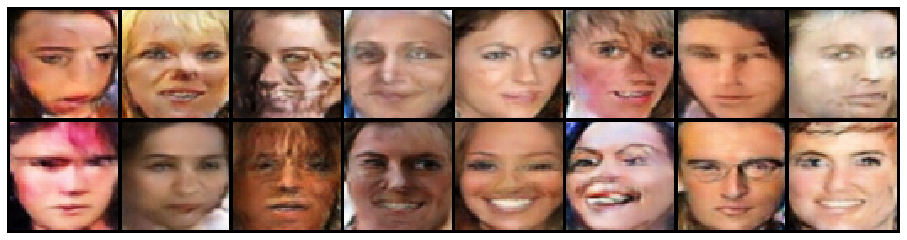

Epoch: [3/5], Batch Num: [420/500]
Discriminator Loss: 1.0992, Generator Loss: 0.7695
D(x): 0.5003, D(G(z)): 0.2746
Epoch: [3/5], Batch Num: [440/500]
Discriminator Loss: 0.9604, Generator Loss: 2.1936
D(x): 0.7221, D(G(z)): 0.4322
Epoch: [3/5], Batch Num: [460/500]
Discriminator Loss: 0.8494, Generator Loss: 1.8252
D(x): 0.6834, D(G(z)): 0.3388
Epoch: [3/5], Batch Num: [480/500]
Discriminator Loss: 0.7651, Generator Loss: 1.7387
D(x): 0.6745, D(G(z)): 0.2767
4
Epoch: [4/5], Batch Num: [0/500]
Discriminator Loss: 0.9997, Generator Loss: 1.3406
D(x): 0.5307, D(G(z)): 0.2511


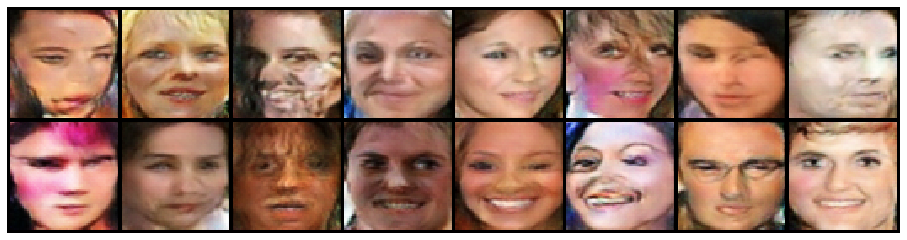

Epoch: [4/5], Batch Num: [20/500]
Discriminator Loss: 0.8356, Generator Loss: 1.7142
D(x): 0.7233, D(G(z)): 0.3663
Epoch: [4/5], Batch Num: [40/500]
Discriminator Loss: 0.9131, Generator Loss: 1.5174
D(x): 0.7189, D(G(z)): 0.4072
Epoch: [4/5], Batch Num: [60/500]
Discriminator Loss: 1.1188, Generator Loss: 0.9022
D(x): 0.4383, D(G(z)): 0.1854
Epoch: [4/5], Batch Num: [80/500]
Discriminator Loss: 0.7831, Generator Loss: 1.5680
D(x): 0.7154, D(G(z)): 0.3287
Epoch: [4/5], Batch Num: [100/500]
Discriminator Loss: 1.0263, Generator Loss: 1.1588
D(x): 0.6537, D(G(z)): 0.4074


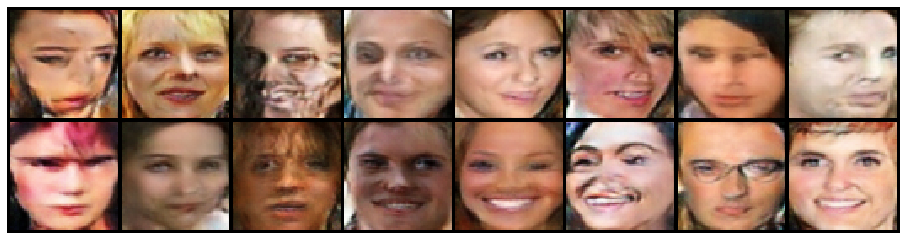

Epoch: [4/5], Batch Num: [120/500]
Discriminator Loss: 1.1354, Generator Loss: 1.4416
D(x): 0.8136, D(G(z)): 0.5531
Epoch: [4/5], Batch Num: [140/500]
Discriminator Loss: 1.6890, Generator Loss: 0.7140
D(x): 0.2674, D(G(z)): 0.1406
Epoch: [4/5], Batch Num: [160/500]
Discriminator Loss: 1.0411, Generator Loss: 1.2951
D(x): 0.5652, D(G(z)): 0.3106
Epoch: [4/5], Batch Num: [180/500]
Discriminator Loss: 0.9046, Generator Loss: 1.1771
D(x): 0.7256, D(G(z)): 0.4081
Epoch: [4/5], Batch Num: [200/500]
Discriminator Loss: 1.1903, Generator Loss: 2.0630
D(x): 0.8721, D(G(z)): 0.6165


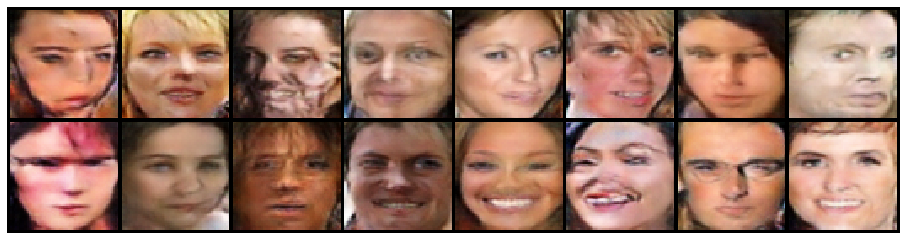

Epoch: [4/5], Batch Num: [220/500]
Discriminator Loss: 0.9838, Generator Loss: 2.0325
D(x): 0.8202, D(G(z)): 0.5107
Epoch: [4/5], Batch Num: [240/500]
Discriminator Loss: 0.9742, Generator Loss: 1.6658
D(x): 0.6708, D(G(z)): 0.3891
Epoch: [4/5], Batch Num: [260/500]
Discriminator Loss: 0.8836, Generator Loss: 1.5691
D(x): 0.6389, D(G(z)): 0.3130
Epoch: [4/5], Batch Num: [280/500]
Discriminator Loss: 1.1291, Generator Loss: 0.6767
D(x): 0.4616, D(G(z)): 0.2326
Epoch: [4/5], Batch Num: [300/500]
Discriminator Loss: 1.2160, Generator Loss: 0.7761
D(x): 0.3920, D(G(z)): 0.1628


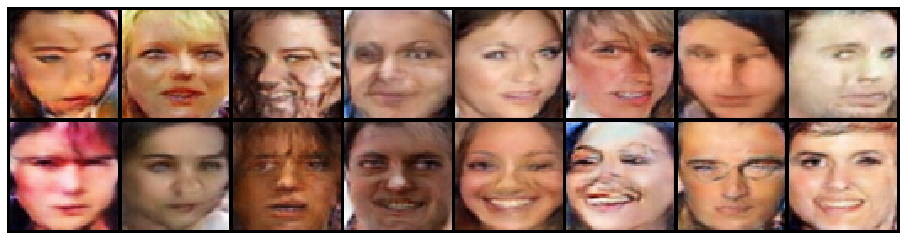

Epoch: [4/5], Batch Num: [320/500]
Discriminator Loss: 0.8541, Generator Loss: 1.2111
D(x): 0.6333, D(G(z)): 0.2792
Epoch: [4/5], Batch Num: [340/500]
Discriminator Loss: 0.8651, Generator Loss: 2.1609
D(x): 0.7803, D(G(z)): 0.4226
Epoch: [4/5], Batch Num: [360/500]
Discriminator Loss: 0.9631, Generator Loss: 1.6440
D(x): 0.6604, D(G(z)): 0.3850
Epoch: [4/5], Batch Num: [380/500]
Discriminator Loss: 0.9193, Generator Loss: 2.2420
D(x): 0.8638, D(G(z)): 0.4931
Epoch: [4/5], Batch Num: [400/500]
Discriminator Loss: 1.0376, Generator Loss: 0.6792
D(x): 0.4577, D(G(z)): 0.1666


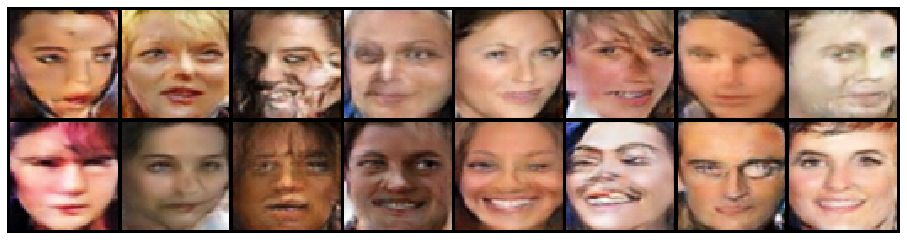

Epoch: [4/5], Batch Num: [420/500]
Discriminator Loss: 0.7681, Generator Loss: 1.3648
D(x): 0.7091, D(G(z)): 0.3132
Epoch: [4/5], Batch Num: [440/500]
Discriminator Loss: 0.9210, Generator Loss: 1.8347
D(x): 0.8125, D(G(z)): 0.4692
Epoch: [4/5], Batch Num: [460/500]
Discriminator Loss: 1.3409, Generator Loss: 1.5034
D(x): 0.3237, D(G(z)): 0.0943
Epoch: [4/5], Batch Num: [480/500]
Discriminator Loss: 0.9129, Generator Loss: 0.9706
D(x): 0.5886, D(G(z)): 0.2722


In [ ]:
# Create logger instance
logger = Logger(model_name='DCGAN', data_name='CelebA')
# Total number of epochs to train
num_epochs = 5

for epoch in range(num_epochs):
    print(epoch)
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if n_batch%20 == 0:
           # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            if (n_batch) % 100 == 0: 
                test_images = vectors_to_images(generator(test_noise))
                test_images = test_images.data.cpu()
                logger.log_images(
                    test_images, num_test_samples, 
                    epoch, n_batch, num_batches
                );

In [ ]:
test_images = vectors_to_images(generator(test_noise))
test_images = test_images.data.cpu()
logger.log_images(
    test_images, num_test_samples, 
    0, 0, 0
    );

In [ ]:
checkpoint = {
    'generator':generator,
    'discriminator':discriminator,
    'gen_stat_dict':generator.state_dict(),
    'dis_stat_dict':discriminator.state_dict(),
    'gen_optimizer':g_optimizer.state_dict(),
    'dis_optimizer':d_optimizer.state_dict()
}

In [ ]:
torch.save(checkpoint,'/content/drive/My Drive/Dataset/checkpoint2.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GeneratorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/loc